In [61]:
import pandas as pd
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from itertools import combinations
from itertools import permutations

In [55]:
normalized_genotype_titers = pd.read_csv('../../data/katzelnick2015/processed/genotypes_normalized.csv', index_col=0)

def fix_name(gt):
    gt = gt[:5]+'_'+gt[5:]
    gt = gt.replace(' ', '').replace('/', '').upper()
    return gt

normalized_genotype_titers['virus_genotype'] = normalized_genotype_titers['virus_genotype'].map(fix_name)
normalized_genotype_titers['serum_genotype'] = normalized_genotype_titers['serum_genotype'].map(fix_name)

genotypes = set(normalized_genotype_titers['virus_genotype'].values)
serotypes = set(normalized_genotype_titers['virus_serotype'].values)

avg_genotype_titers = normalized_genotype_titers.groupby(['virus_genotype', 'serum_genotype'])['autologous_norm'].agg('mean')
avg_serotype_titers = normalized_genotype_titers.groupby(['virus_serotype', 'serum_serotype'])['autologous_norm'].agg('mean')

In [56]:
def check_symmetry(series, clades):
    pairs = [tuple(sorted(p)) for p in combinations(clades, 2) if p[0] != p[1]]
    
    intraserotype = {}
    interserotype = {}

    for p in pairs:
        try:
            A = series[p[0]][p[1]]
            B = series[p[1]][p[0]]
            if p[0][:5] == p[1][:5]:
                intraserotype[p] = (A, B)
            else:
                interserotype[p] = (A,B)
        except KeyError:
            continue
    return {'inter': interserotype, 'intra': intraserotype}
    
    
symmetry = check_symmetry(avg_genotype_titers, genotypes)


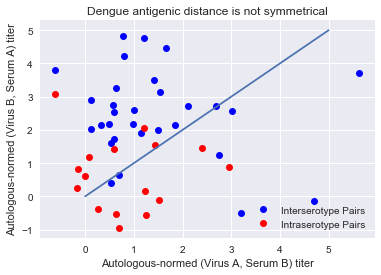

In [57]:
fig, ax = plt.subplots()

inter_x,inter_y = zip(*symmetry['inter'].values())
intra_x, intra_y = zip(*symmetry['intra'].values())

ax.plot(inter_x, inter_y, 'o', c = 'blue', label='Interserotype Pairs')
ax.plot(intra_x, intra_y, 'o', c = 'red', label='Intraserotype Pairs')
ax.plot(range(6), range(6), '-')
plt.title('Dengue antigenic distance is not symmetrical')
plt.xlabel('Autologous-normed (Virus A, Serum B) titer')
plt.ylabel('Autologous-normed (Virus B, Serum A) titer')
plt.legend()
plt.show()

In [62]:
def fill_missing_titers(titers=normalized_genotype_titers, genotypes=genotypes,
                        genotype_titers=avg_genotype_titers, serotype_titers=avg_serotype_titers):
    
    # All pairs of genotypes in the frequency data (in both orders)
    genotype_pairs = [p for p in permutations(genotypes, 2)]
    
    # Pull average titers for VIRUS from a given GENOTYPE titered against SERA from each SEROTYPE
    genotype_serotype_titers = titers.groupby(['virus_genotype', 'serum_serotype'])['autologous_norm'].agg('mean')
    
    # Find where we don't have values for VIRUS GENOTYPE : SERUM GENOTYPE
    missing_genotypes = [p for p in genotype_pairs 
                         if p not in genotype_titers.index
                         or np.isnan(genotype_titers[p])]
    
    
    missing_genotype_vals = pd.DataFrame({'virus_genotype':[p[0] for p in missing_genotypes],
                             'serum_genotype':[p[1] for p in missing_genotypes],
                             'serum_serotype':[p[1].split('_')[0] for p in missing_genotypes],
                             'autologous_norm': [np.nan for p in missing_genotypes]})
    
    def fill(row):
        try:
            row['autologous_norm'] = genotype_serotype_titers[(row['virus_genotype'], row['serum_serotype'])]
        except KeyError:
            row['autologous_norm'] = np.nan
        return row

    # Fill in missing values
    filled_genotype_vals = missing_genotype_vals.apply(fill, axis=1)
    # Wrangle the axes so they're in the same multiindex form as genotype_titers
    filled_genotype_vals = filled_genotype_vals.groupby(['virus_genotype', 'serum_genotype'])['autologous_norm'].apply(list).apply(pd.Series)
    filled_genotype_vals.rename(columns={0:'autologous_norm'}, inplace=True)

    # Merge the filled values in with a copy of genotype_titers
    filled_genotype_titers = genotype_titers.copy()
    filled_genotype_titers = filled_genotype_titers.combine_first(filled_genotype_vals['autologous_norm'])
    return filled_genotype_titers
    
filled_genotype_titers = fill_missing_titers()

In [69]:
print filled_genotype_titers.head(10)
print 'Unfilled / missing values: %d'%len(filled_genotype_titers[filled_genotype_titers.isnull()])

virus_genotype  serum_genotype     
DENV1_I         DENV1_I                0.653049
                DENV1_II               0.181842
                DENV1_IV              -0.609196
                DENV1_V                0.585899
                DENV2_AMERICAN         1.415378
                DENV2_ASIANAMERICAN    5.630129
                DENV2_ASIANI           1.977345
                DENV2_ASIANII          1.977345
                DENV2_COSMOPOLITAN     1.977345
                DENV2_SYLVATIC         1.977345
Name: autologous_norm, dtype: float64
Unfilled / missing values: 3


In [71]:
filled_genotype_titers.to_csv('../../data/katzelnick2015/processed/genotypes_normalized_filled.csv')